In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
klin = np.loadtxt('../flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('../flowpm/data/Planck15_a1p00.txt').T[1]
stages = np.linspace(0.1, 1.0, 10, endpoint=True)

In [4]:
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline

ipklin = iuspline(klin, plin)

In [5]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import mesh_tensorflow as mtf

Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
# Define the cluster
cluster = tf.train.ClusterSpec({"mesh": ["localhost:2222", "localhost:2223"]})

In [7]:
# import flowpm.mesh_ops as mpm
import flowpm
import flowpm.mesh_utils as mpu
import flowpm.mtfpm as fpm
import tensorflow_probability as tfp

from flowpm import mesh_ops
from flowpm import mesh_utils
from flowpm import mesh_kernels

graph = mtf.Graph()
mesh = mtf.Mesh(graph, "my_mesh")

batch_size = 1
boxsize=100
nc = 128       # Native resolution of the grid

# Parameters of the small scales decomposition
n_block_x = 2
n_block_y = 1
n_block_z = 1
halo_size = 32

# Parameters of the large scales decomposition
downsampling_factor = 2
lnc = nc // 2**downsampling_factor 

fx_dim = mtf.Dimension("nx", nc)
fy_dim = mtf.Dimension("ny", nc)
fz_dim = mtf.Dimension("nz", nc)

# Dimensions of the low resolution grid
x_dim = mtf.Dimension("nx_lr", lnc)
y_dim = mtf.Dimension("ny_lr", lnc)
z_dim = mtf.Dimension("nz_lr", lnc)

nx_dim = mtf.Dimension('nx_block', n_block_x)
ny_dim = mtf.Dimension('ny_block', n_block_y)
nz_dim = mtf.Dimension('nz_block', n_block_z)

sx_dim = mtf.Dimension('sx_block', nc//n_block_x)
sy_dim = mtf.Dimension('sy_block', nc//n_block_y)
sz_dim = mtf.Dimension('sz_block', nc//n_block_z)

batch_dim = mtf.Dimension("batch", batch_size)
pk_dim = mtf.Dimension("npk", len(plin))
pk = mtf.import_tf_tensor(mesh, plin.astype('float32'), shape=[pk_dim])

In [8]:
# kvec for low resolution grid
kvec_lr = flowpm.kernels.fftk([lnc, lnc, lnc], symmetric=False) 

kx_lr = mtf.import_tf_tensor(mesh, kvec_lr[0].squeeze().astype('float32')/ 2**downsampling_factor, shape=[x_dim])
ky_lr = mtf.import_tf_tensor(mesh, kvec_lr[1].squeeze().astype('float32')/ 2**downsampling_factor, shape=[y_dim])
kz_lr = mtf.import_tf_tensor(mesh, kvec_lr[2].squeeze().astype('float32')/ 2**downsampling_factor, shape=[z_dim])
kv_lr = [kx_lr, ky_lr, kz_lr]

# kvec for high resolution blocks
padded_sx_dim = mtf.Dimension('padded_sx_block', nc//n_block_x+2*halo_size)
padded_sy_dim = mtf.Dimension('padded_sy_block', nc//n_block_y+2*halo_size)
padded_sz_dim = mtf.Dimension('padded_sz_block', nc//n_block_z+2*halo_size)
kvec_hr = flowpm.kernels.fftk([nc//n_block_x+2*halo_size, nc//n_block_y+2*halo_size, nc//n_block_z+2*halo_size], symmetric=False)

kx_hr = mtf.import_tf_tensor(mesh, kvec_hr[0].squeeze().astype('float32'), shape=[padded_sx_dim])
ky_hr = mtf.import_tf_tensor(mesh, kvec_hr[1].squeeze().astype('float32'), shape=[padded_sy_dim])
kz_hr = mtf.import_tf_tensor(mesh, kvec_hr[2].squeeze().astype('float32'), shape=[padded_sz_dim])
kv_hr = [kx_hr, ky_hr, kz_hr]

In [9]:
lr_shape = [batch_dim, 
            x_dim, y_dim, z_dim]

In [10]:
hr_shape = [batch_dim, 
            nx_dim, ny_dim, nz_dim,
            sx_dim, sy_dim, sz_dim]

In [11]:
part_shape = [batch_dim, fx_dim, fy_dim, fz_dim]

In [12]:
lr_shape

[Dimension(name='batch', size=1),
 Dimension(name='nx_lr', size=32),
 Dimension(name='ny_lr', size=32),
 Dimension(name='nz_lr', size=32)]

In [13]:
hr_shape

[Dimension(name='batch', size=1),
 Dimension(name='nx_block', size=2),
 Dimension(name='ny_block', size=1),
 Dimension(name='nz_block', size=1),
 Dimension(name='sx_block', size=64),
 Dimension(name='sy_block', size=128),
 Dimension(name='sz_block', size=128)]

In [14]:
hr_shape[1:4]

[Dimension(name='nx_block', size=2),
 Dimension(name='ny_block', size=1),
 Dimension(name='nz_block', size=1)]

In [15]:
initial_conditions = flowpm.linear_field(nc,          # size of the cube
                                         boxsize,     # Physical size of the cube
                                         ipklin,      # Initial powerspectrum
                                         batch_size=batch_size)
initc = tf.reshape(initial_conditions, [1, 2, 1, 1, nc//2, nc, nc])

field = mtf.import_tf_tensor(mesh, initc, shape=hr_shape)


for block_size_dim in hr_shape[-3:]:
    field = mtf.pad(field, [halo_size, halo_size], block_size_dim.name)

for blocks_dim, block_size_dim in zip(hr_shape[1:4], field.shape[-3:]):
    field = mesh_ops.halo_reduce(field, blocks_dim, block_size_dim, halo_size)

field = mtf.reshape(field, field.shape+[mtf.Dimension('h_dim', 1)])
high = field
low = mesh_utils.downsample(field, downsampling_factor, antialias=True)

low = mtf.reshape(low, low.shape[:-1])
high = mtf.reshape(high, high.shape[:-1])

for block_size_dim in hr_shape[-3:]:
    low = mtf.slice(low, halo_size//2**downsampling_factor, block_size_dim.size//2**downsampling_factor, block_size_dim.name)
low = mtf.reshape(low, lr_shape)

In [16]:
state = fpm.lpt_init(low, high, 0.1, kv_lr, kv_hr, halo_size, hr_shape, lr_shape, part_shape[1:],
                            downsampling_factor=downsampling_factor, antialias=True,)

In [17]:
# Here we can run our nbody
final_state = fpm.nbody(state, stages, lr_shape, hr_shape, kv_lr, kv_hr, halo_size, downsampling_factor=downsampling_factor)

In [18]:
# paint the field
final_field = mtf.zeros(mesh, shape=hr_shape)
for block_size_dim in hr_shape[-3:]:
    final_field = mtf.pad(final_field, [halo_size, halo_size], block_size_dim.name)
final_field = mpu.cic_paint(final_field, final_state[0], halo_size)
# Halo exchange
for blocks_dim, block_size_dim in zip(hr_shape[1:4], final_field.shape[-3:]):
    final_field = mesh_ops.halo_reduce(final_field, blocks_dim, block_size_dim, halo_size)
# Remove borders
for block_size_dim in hr_shape[-3:]:
    final_field = mtf.slice(final_field, halo_size, block_size_dim.size, block_size_dim.name)

In [19]:
final_field = mtf.reshape(final_field,  [batch_dim, fx_dim, fy_dim, fz_dim])

In [20]:
# Let's have a look!
devices = ["/job:mesh/task:%d"%i for i in range(cluster.num_tasks("mesh"))]
mesh_shape = [("row", 2), ("col", 1)]
layout_rules = [("nx_lr", "row"), ("ny_lr", "col"),
                ("nx", "row"), ("ny", "col"),
                ("nx_block","row"), ("ny_block","col")]

mesh_impl = mtf.placement_mesh_impl.PlacementMeshImpl(
    mesh_shape, layout_rules, devices)

lowering = mtf.Lowering(graph, {mesh:mesh_impl})

tf_field = lowering.export_to_tf_tensor(final_field)

INFO:tensorflow:Counters:
alltoall: 8.22e+06
 alltoall/0: 2.88e+06
  alltoall/0/reshape_op: 2.88e+06
 alltoall/1: 5.34e+06
  alltoall/1/reshape_op: 5.34e+06
conv3d: 2.02e+10
 conv3d/forward: 2.02e+10
conv3d_transpose: 2.4e+11
 conv3d_transpose/forward: 2.4e+11
conv3d_transpose_unique: 2.4e+11
 conv3d_transpose_unique/forward: 2.4e+11
conv3d_unique: 2.02e+10
 conv3d_unique/forward: 2.02e+10
einsum: 1.21e+07
einsum_unique: 1.21e+07
output: 1.13e+10
 output/AddOperation: 1.78e+09
 output/Constant: 2.31e+07
 output/Conv3dOperation: 6.49e+07
 output/Conv3dTransposeOperation: 7.01e+08
 output/EinsumOperation: 1.21e+07
 output/ImportOperation: 2.26e+06
 output/IndicesOperation: 6.29e+06
 output/PadOperation: 1.31e+09
 output/ReshapeOperation: 1.47e+09
 output/ScalarMultiplyOperation: 3.15e+08
 output/ShiftOperation: 2.76e+08
 output/SliceOperation: 3.66e+08
 output/SlicewiseOperation: 4.91e+09
 output/StackOperation: 6.92e+07
output_unique: 1.13e+10
 output_unique/AddOperation: 1.78e+09
 outp

In [21]:
# Compute evolution of the field using standard FlowPM
state = flowpm.lpt_init(initial_conditions, a0=0.1,order=1) 
final_state = flowpm.nbody(state,  stages, nc)
tfinal_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])

In [22]:
with tf.Session("grpc://localhost:2222") as sess:
    fin_ref, fin = sess.run([tfinal_field , tf_field])

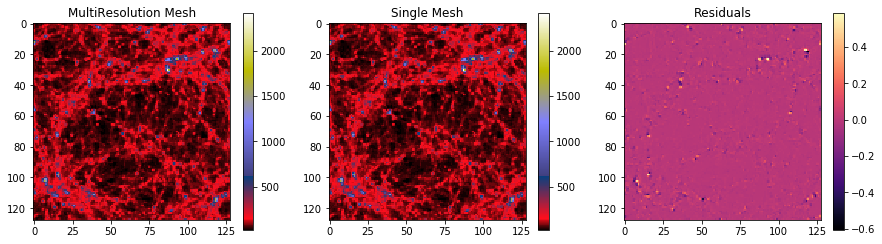

In [23]:
figure(figsize=(15,4))
subplot(131)
imshow((fin)[0,].sum(axis=2),cmap='gist_stern'); colorbar();
title('MultiResolution Mesh')
subplot(132)
imshow(fin_ref[0,].sum(axis=2),cmap='gist_stern'); colorbar();
title('Single Mesh')
subplot(133)
imshow((fin_ref - fin)[0,].sum(axis=2),cmap='magma'); colorbar();
title('Residuals')
savefig('figname.png',  transparent=False)

In [24]:
from nbodykit.lab import *
from nbodykit import setup_logging, style

ModuleNotFoundError: No module named 'nbodykit'